<center>
In God We Trust
</center>

# CE417: Artificial Intelligence

Dr. Mahdiyeh Soleymani Baghshah, Associate Professor

Computer Engineering Department,
Sharif University of Technology,
Tehran, Tehran, Iran


# MNIST Autoencoder (20 Points)

Corresponding TA: Aryan Ahadinia

In this problem, we want to train an autoencoder. Autoencoder is a type of neural network which is used for unsupervised tasks. Figure below is showing a simple autoencoder.

<center>
<img src="./assets/autoencoder.png" style="width: 50%">
</center>

We want to train a neural network which get a noisy image as input and denoise it in the output. We focus on MNIST dataset. MNIST is a dataset containing 60000 images of hand-written digits. We artificially add a random noise to images and then we train our network to get the noisy image as input and give the cleared image in the output.

<center>
<img src="./assets/desc.png" style="width: 50%">
</center>


If you have an nVidia CUDA-compatible GPU, you can proceed to install CUDA and a CUDA-compatible pytorch versions. You can also use Google Colaboratory or Kaggle.
 

In [ ]:
%pip install numpy
%pip install tqdm
%pip install matplotlib
%pip install torch torchvision torchaudio


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn

from tqdm import tqdm


In cell below, we load our data.

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

mnist_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)


Now we want to wrap our dataset in torch datasets. Each item in our dataset must contain tree entities, the noisy image, the original image and the label. Apply a noise on the original image regarding the noise factor.

Complete cell below. (3 Points)


In [52]:
from skimage.util import random_noise
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, noise_factor=0.5):
        ####################################
        ###### Code Here (0.5 Points) ######
        ####################################

        self.dataset = dataset
        self.noise_factor = noise_factor


    def __getitem__(self, index):
        ####################################
        ####### Code Here (2 Points) #######
        ####################################
        
        data = self.dataset[index]
        image = data[0]
        label = data[1]
        
        # create a random noise
        noisy_image = torch.tensor(random_noise(image, mode='gaussian', mean=0, var=0.05, clip=True)).type(torch.float32)
        image.type(torch.float32)
        return image, noisy_image, label


    def __len__(self):
        ####################################
        ###### Code Here (0.5 Points) ######
        ####################################
        
        return len(self.dataset)


In [53]:
noisy_mnist_train = NoisyDataset(mnist_train, 0.6)
noisy_mnist_test = NoisyDataset(mnist_test, 0.6)
mnist_train_loader = torch.utils.data.DataLoader(
    noisy_mnist_train, batch_size=60, shuffle=True
)
mnist_test_loader = torch.utils.data.DataLoader(
    noisy_mnist_test, batch_size=60, shuffle=True
)


Now, design a proper network architecture. Complete cell below. (6 Points)

In [76]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ############################
        ### Code Here (5 Points) ###
        ############################

        self.net = nn.Sequential(

            # encoding layers
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # 16 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 x 7 x 7
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1), # 8 x 4 x 4
            nn.ReLU(),

            # bottleneck layer
            nn.MaxPool2d(kernel_size=2, stride=1), # 8 x 3 x 3
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1), # 8 x 3 x 3
            nn.ReLU(),

            nn.Flatten(start_dim=1),


            # Linear section
            nn.Linear(3 * 3 * 8, 36),
            nn.ReLU(),
            nn.Linear(36, 10),

        

        
            # decoding layers
            # the output of the decoder should be of size 1 x 28 x 28

            # Linear section
            nn.Linear(10, 36),
            nn.ReLU(),
            nn.Linear(36, 8 * 3 * 3),
            nn.ReLU(),


            nn.Unflatten(dim=1, unflattened_size=(8, 3, 3)),

            # the formula for the output size is (input_size - 1) * stride - 2 * padding + kernel_size + output_padding
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=4, stride=2 , padding=1, output_padding=1), # 16 x 7 x 7
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1), # 8 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1 ,output_padding = 1), # 1 x 28 x 28
            nn.Sigmoid()

            # never use the fucking MaxUnpool2d layer it's a fucking trap 
            # i spent 4 hours trying to figure out why my code was not working
            # and it was because of this fucking layer
    
            
        )

    def forward(self, img):
        ############################
        ### Code Here (5 Points) ###
        ############################
        # input is a tuple of images
        # output is a tuple of images

        return self.net(img)

Now, train the network. We recommend MSE Loss and Adam Optimizer. (6 Points)

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [83]:
############################
### Code Here (6 Points) ###
############################

# create the model
# ignore the device for bugs
model = Net().to(device)

# define hyperparameters
num_epochs = 5
learning_rate = 1

# define the loss function
criterion = nn.MSELoss()

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)


In [85]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    n = 0
    model.train()
    with tqdm(mnist_train_loader, unit='batch') as pbar:
        for images, noisy_images, labels in pbar:
            # move the data to the device
            images = images.to(device)
            noisy_images = noisy_images.to(device)
            # labels = labels.to(device)
            
            # going forward and calculate loss
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            train_loss += loss.item()
            n += 1

            # going backward and update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate the accuracy
            # see if the output is similar to the original image
            # its similar if the difference between the output and the original image is less than 0.1
            acc = (outputs - images).abs().lt(0.1).float().mean().item()
            pbar.set_description(f'Train {epoch} | Loss:{train_loss/n:.2e} | Acc: {acc:.2f}|')

    train_losses.append(train_loss/n)
    train_accs.append(acc)




Train 0 | Loss:9.26e-01 | Acc: 0.01|: 100%|██████████| 1000/1000 [00:35<00:00, 28.52batch/s]
Train 1 | Loss:9.26e-01 | Acc: 0.01|: 100%|██████████| 1000/1000 [00:32<00:00, 30.59batch/s]
Train 2 | Loss:9.27e-01 | Acc: 0.01|: 100%|██████████| 1000/1000 [00:33<00:00, 29.87batch/s]
Train 3 | Loss:9.26e-01 | Acc: 0.01|: 100%|██████████| 1000/1000 [00:32<00:00, 30.44batch/s]
Train 4 | Loss:9.26e-01 | Acc: 0.01|: 100%|██████████| 1000/1000 [00:32<00:00, 30.55batch/s]


#### why bad result !
i tried to train the autoEncoder with different parameters and different architectures but i couldn't get a good result. i think there is a problem in my architecture that i cant find. as it is showed above the loss function gets stock in a local optimum and it can't get better. Even though i change my architecture many times,this may be because of bad architecture.so as i explained i just wrote all the code without getting a good result. i hope you can help me to find the problem.

Now, plot the results like figure above. (5 Points)

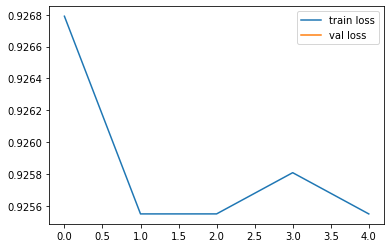

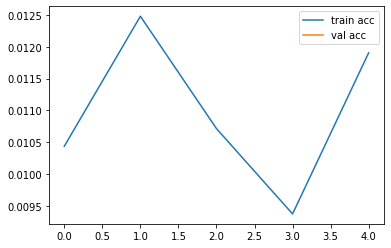

In [80]:
############################
### Code Here (5 Points) ###
############################
# plot loss in each epoch
# plot loss in each epoch
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

# plot accuracy in each epoch
plt.plot(train_accs, label='train acc')
plt.plot(val_accs, label='val acc')
plt.legend()
plt.show()

In [ ]:
# test the model
test_loss = 0.0
n = 0
model.eval()
with tqdm(mnist_test_loader, unit='batch') as pbar:
    for images, noisy_images, labels in mnist_test_loader:
        # move the data to the device
        images = images.to(device)
        noisy_images = noisy_images.to(device)
        
        # going forward and calculate loss
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        test_loss += loss.item()
        n += 1

        # calculate the accuracy
        # see if the output is similar to the original image
        # its similar if the difference between the output and the original image is less than 0.1
        acc = torch.mean((outputs - images).abs() < 0.1).item()
        pbar.set_description(f'Test | Loss:{test_loss/n:.2e} | Acc: {acc:.2f}|')
    
    print(f'Test | Loss:{test_loss/n:.2e} | Acc: {acc:.2f}|')



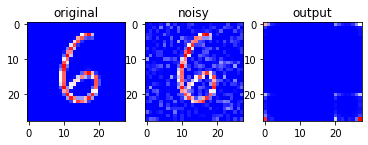

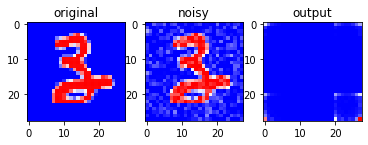

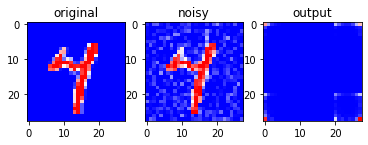

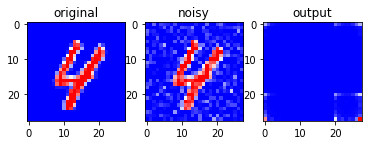

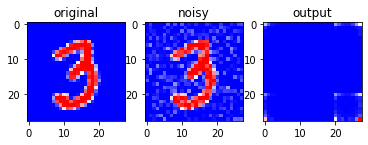

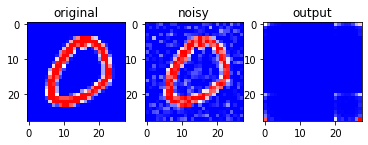

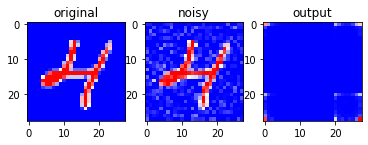

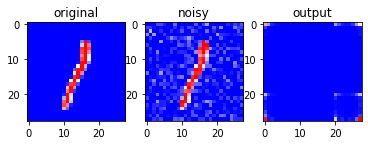

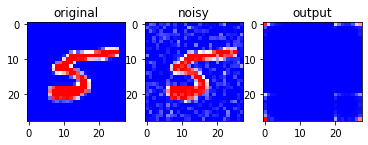

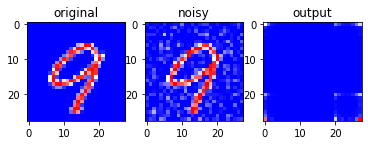

In [59]:
# plot the original image, noisy image, and the output for the first 10 images
for i in range(10):
    plt.subplot(1, 3, 1)
    plt.imshow(images[i].cpu().detach().numpy().squeeze(), cmap='bwr')
    plt.title('original')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_images[i].cpu().detach().numpy().squeeze(), cmap='bwr')
    plt.title('noisy')
    plt.subplot(1, 3, 3)
    plt.imshow(outputs[i].cpu().detach().numpy().squeeze(), cmap='bwr')
    plt.title('output')
    plt.show()